In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import albumentations as A
import cv2
import interpretability_toolkit.attributions as attr
import timm
import torch
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from imagenet1000_clsidx_to_labels import labels
from interpretability_toolkit.utils.plots import plot_images_heatmaps

Attribution = attr.Attribution

In [3]:
list_models = ["vit_small_patch8_224.dino"]
model = timm.create_model(list_models[0], pretrained=True)

In [4]:
img = cv2.imread("n01558993_robin.JPEG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = A.Compose([A.Resize(*model.pretrained_cfg['input_size'][1:], mode=model.pretrained_cfg['interpolation']),
                       A.Normalize(mean=model.pretrained_cfg['mean'], 
                                   std=model.pretrained_cfg['std']), ToTensorV2()])
img = transform(image=img)["image"].unsqueeze(0)


Generating heatmap with method:  attention_rollout


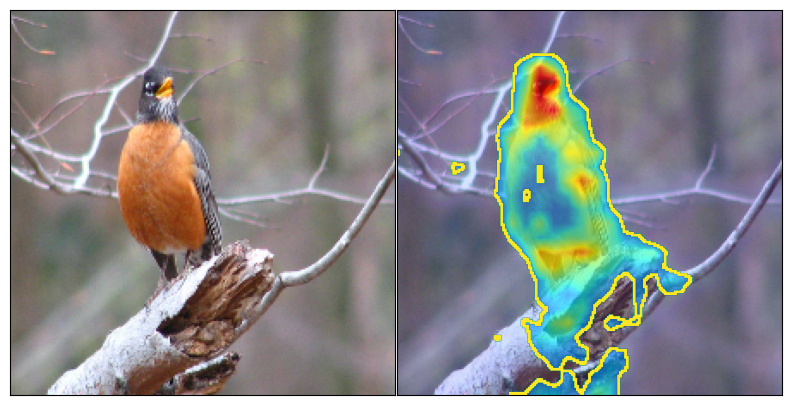

Generating heatmap with method:  chefer


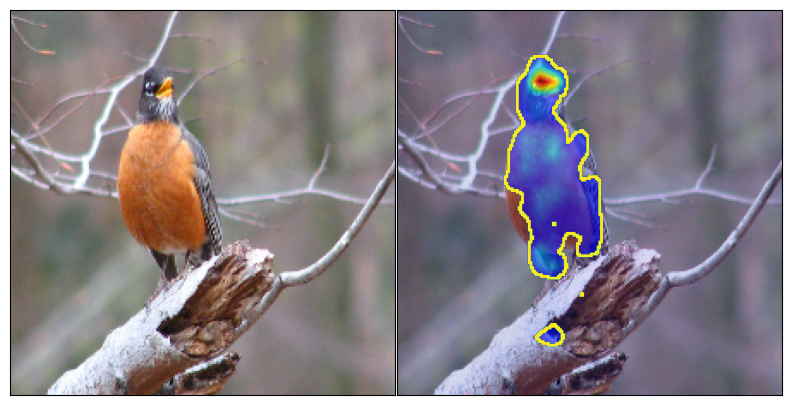

Generating heatmap with method:  focused_attention


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


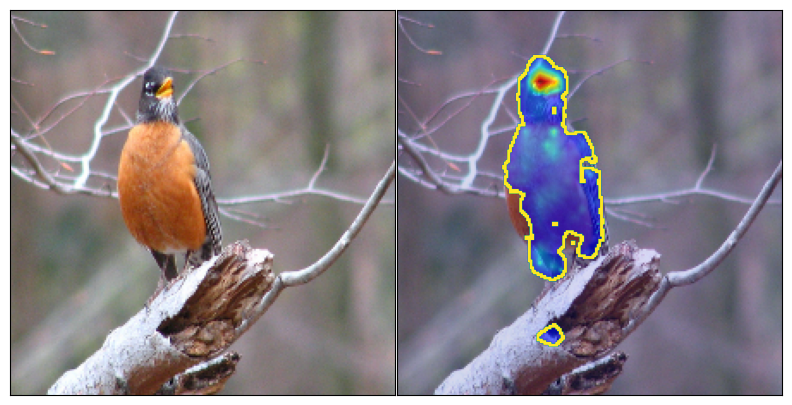

In [5]:
model = model.cuda(0)
attr = Attribution(model, sampling_points=1024, with_replacement=False, temperature=2., dilate_tokens=False, 
                   attribution_method='chefer', noise_level=0.) 

cat = 284
dog  = 232
bird = 15
show_label  = bird
img = img.cuda(0)

methods = ["attention_rollout", "chefer", "focused_attention"]
for m in methods:
    print("Generating heatmap with method: ", m)
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            pred = model(img)      
        pred = pred.argmax().item()
        attributions = attr.attribute(img, method=m, output=show_label, discard_ratio=0., start_from=-8, 
                                    head_fusion="max")
        attributions = torch.nan_to_num(attributions, nan=0.0)
    fig = plot_images_heatmaps(img, attributions, border_width=3, cmap='jet', threshold="otsu", use_sigmoid=True)
    plt.show()


In [6]:
list_models = ["convnext_base.fb_in22k"]
model = timm.create_model(list_models[0], pretrained=True)

img = cv2.imread("n01558993_robin.JPEG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = A.Compose([A.Resize(*model.pretrained_cfg['input_size'][1:], mode=model.pretrained_cfg['interpolation']),
                       A.Normalize(mean=model.pretrained_cfg['mean'], 
                                   std=model.pretrained_cfg['std']), ToTensorV2()])
img = transform(image=img)["image"].unsqueeze(0)


Generating heatmap with method:  ig


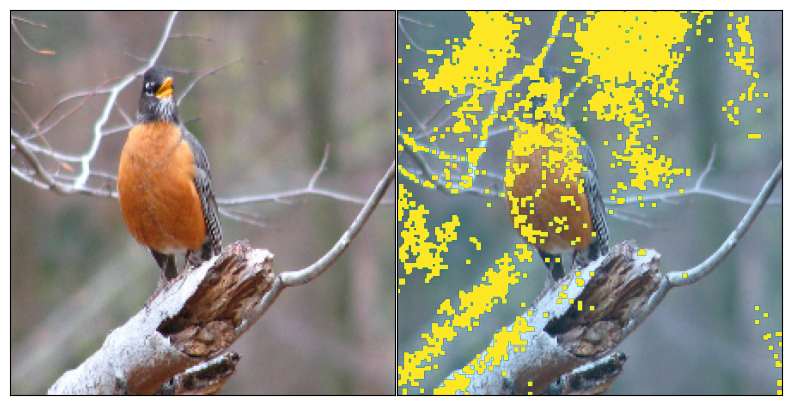

Generating heatmap with method:  guided_gradcam


/home/clement/miniforge-pypy3/envs/deeplearning/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/clement/miniforge-pypy3/envs/deeplearning/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


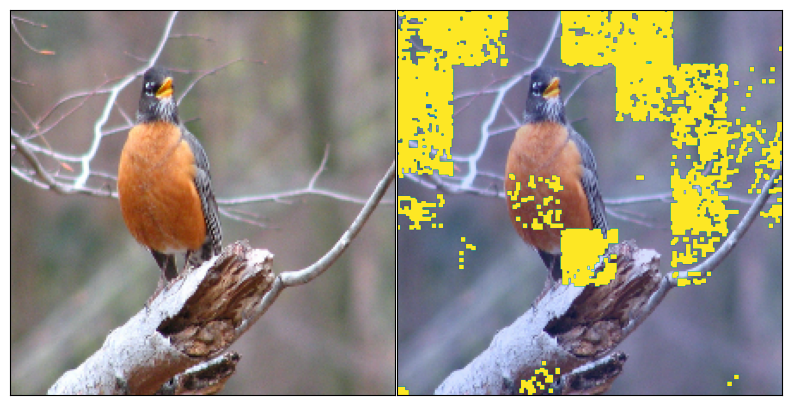

Generating heatmap with method:  gradcam


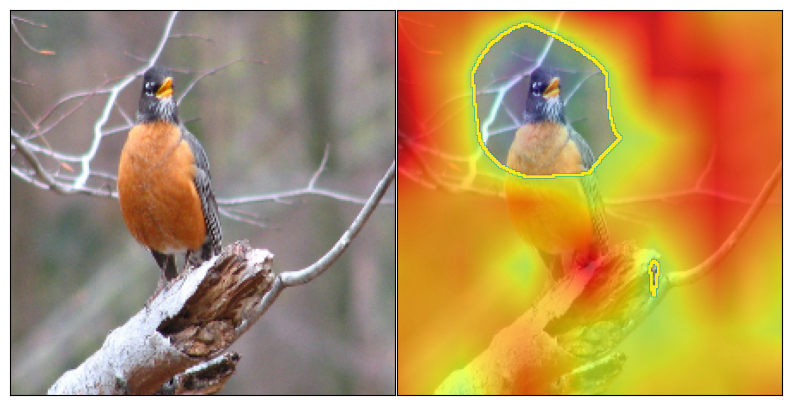

Generating heatmap with method:  deep_lift


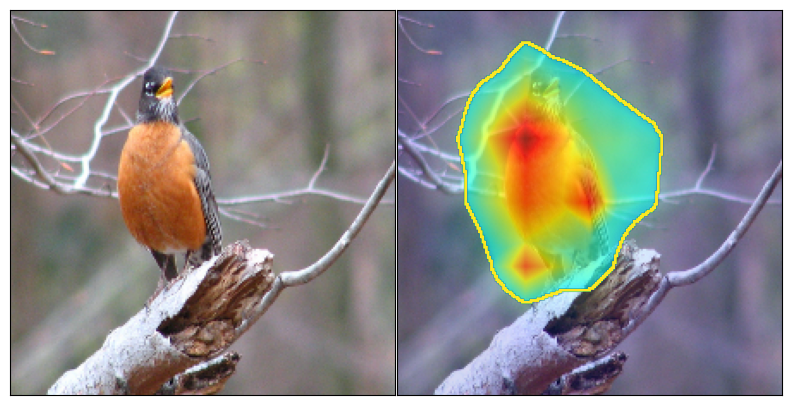

In [9]:
model = model.cuda(0)

cat = 284
dog  = 232
bird = 15
show_label  = bird
img = img.cuda(0)

methods = ["ig", "guided_gradcam", "gradcam", "deep_lift"]
for m in methods:
    attr = Attribution(model, sampling_points=1024, with_replacement=False, temperature=2., dilate_tokens=False, 
                   attribution_method='chefer', noise_level=0.) 

    print("Generating heatmap with method: ", m)
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            pred = model(img)      
        pred = pred.argmax().item()
        attributions = attr.attribute(img, method=m, target=show_label)
        attributions = torch.nan_to_num(attributions, nan=0.0)
    fig = plot_images_heatmaps(img, attributions, border_width=3, cmap='jet', threshold="otsu", use_sigmoid=True)
    plt.show()
